In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

# Set up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load and preprocess the CIFAR-10 dataset
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

100%|██████████| 170M/170M [00:02<00:00, 66.6MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
# Load pre-trained ResNet-18 model
import torchvision.models as models

model = models.resnet18(pretrained=True)

# Modify the final layer for CIFAR-10
num_classes = 10
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

# Function to create a random patch
def create_patch(patch_size=(3, 3)):
    patch = torch.randn(3, *patch_size, requires_grad=True, device=device)
    return patch

# Function to apply the patch to images
def place_patch(img, patch):
    batch_size, _, h, w = img.size()
    ph, pw = patch.size(1), patch.size(2)
    for i in range(batch_size):
        x_offset = torch.randint(0, h - ph + 1, (1,)).item()
        y_offset = torch.randint(0, w - pw + 1, (1,)).item()
        img[i, :, x_offset:x_offset+ph, y_offset:y_offset+pw] = patch
    return img

# Training function for adversarial patch
def patch_training_step(model, patch, target_class=None, dataloader=None, optimizer=None, criterion=None):
    model.train()
    total_loss = 0
    for images, _ in dataloader:
        images = images.to(device)
        optimizer.zero_grad()
        patched_images = place_patch(images, patch)
        outputs = model(patched_images)
        if target_class is not None:
            labels = torch.full((images.size(0),), target_class, dtype=torch.long, device=device)
        else:
            labels = torch.randint(0, 10, (images.size(0),), device=device)  # Random class for untargeted attack
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    return total_loss / len(dataloader)

# Function to train the adversarial patch
def train_adversarial_patch(model, patch, target_class=None, num_epochs=10):
    patch_optimizer = optim.Adam([patch], lr=0.01)
    criterion = nn.CrossEntropyLoss()
    for epoch in range(num_epochs):
        loss = patch_training_step(model, patch, target_class, trainloader, patch_optimizer, criterion)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss:.4f}")

# Function to evaluate the success rate of the adversarial patch
def evaluate_patch_success_rate(model, patch, dataloader, target_class=None):
    model.eval()
    successful_attacks = 0
    total_samples = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            patched_images = place_patch(images.clone(), patch)
            outputs = model(patched_images)
            _, predicted = outputs.max(1)

            # Count successful targeted attacks (where prediction matches the target class)
            if target_class is not None:
                successful_attacks += (predicted == target_class).sum().item()
            total_samples += labels.size(0)

    success_rate = 100 * successful_attacks / total_samples
    print(f"Targeted Attack Success Rate: {success_rate:.2f}%")
    return success_rate

# Function to visualize the patch
def visualize_patch(patch):
    patch = patch.detach().cpu().numpy()
    patch = np.clip((patch - patch.min()) / (patch.max() - patch.min()), 0, 1)

    plt.figure(figsize=(2, 2))
    plt.imshow(np.transpose(patch, (1, 2, 0)))  # [C, H, W] -> [H, W, C]
    plt.title("Adversarial Patch")
    plt.axis('off')
    plt.show()

# Function to visualize misclassified patched images
def visualize_misclassified_patched_images(model, patch, dataloader, classes, target_class, num_examples=5):
    model.eval()
    examples_shown = 0
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        patched_images = place_patch(images.clone(), patch)
        with torch.no_grad():
            original_preds = model(images).argmax(dim=1)
            patched_preds = model(patched_images).argmax(dim=1)
        for i in range(images.size(0)):
            if patched_preds[i] == target_class:  # Targeted attack
                original_image = (images[i].cpu().detach().numpy().transpose(1, 2, 0) * 0.5) + 0.5
                patched_image = (patched_images[i].cpu().detach().numpy().transpose(1, 2, 0) * 0.5) + 0.5

                fig, axes = plt.subplots(1, 2, figsize=(4, 4))
                axes[0].imshow(np.clip(original_image, 0, 1))
                axes[0].set_title(f"Original Image\nTrue Label: {classes[labels[i].item()]}\nPredicted: {classes[original_preds[i].item()]}")

                axes[1].imshow(np.clip(patched_image, 0, 1))
                axes[1].set_title(f"Image with Adversarial Patch\nTrue Label: {classes[labels[i].item()]}\nPredicted: {classes[patched_preds[i].item()]}")

                plt.show()
                examples_shown += 1
                if examples_shown >= num_examples:
                    return

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 161MB/s]



Training for patch size: (3, 3) with target class: plane
Epoch 1/20, Loss: 3.3807
Epoch 2/20, Loss: 3.3820
Epoch 3/20, Loss: 3.3785
Epoch 4/20, Loss: 3.3781
Epoch 5/20, Loss: 3.3805
Epoch 6/20, Loss: 3.3816
Epoch 7/20, Loss: 3.3775
Epoch 8/20, Loss: 3.3770
Epoch 9/20, Loss: 3.3773
Epoch 10/20, Loss: 3.3769
Epoch 11/20, Loss: 3.3779
Epoch 12/20, Loss: 3.3752
Epoch 13/20, Loss: 3.3736
Epoch 14/20, Loss: 3.3746
Epoch 15/20, Loss: 3.3768
Epoch 16/20, Loss: 3.3738
Epoch 17/20, Loss: 3.3749
Epoch 18/20, Loss: 3.3744
Epoch 19/20, Loss: 3.3728
Epoch 20/20, Loss: 3.3732
Visualizing patch of size (3, 3) for target class plane


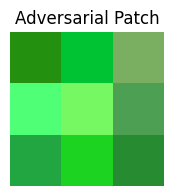

Targeted Attack Success Rate: 0.77%


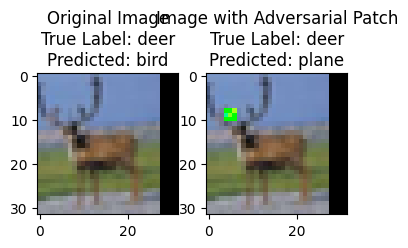

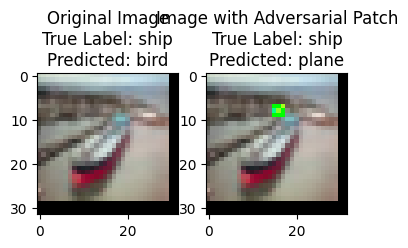

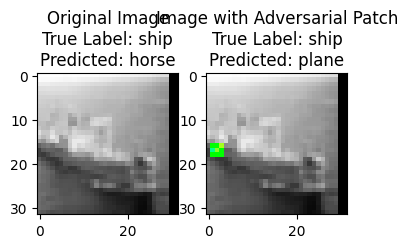

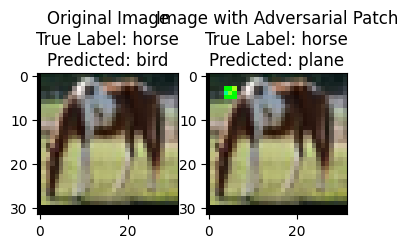

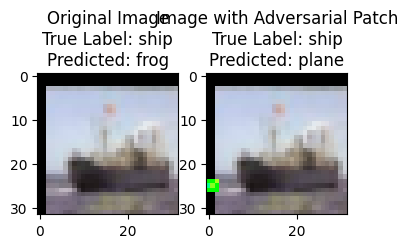


Training for patch size: (5, 5) with target class: plane
Epoch 1/20, Loss: 3.3833
Epoch 2/20, Loss: 3.3818
Epoch 3/20, Loss: 3.3800
Epoch 4/20, Loss: 3.3790
Epoch 5/20, Loss: 3.3773
Epoch 6/20, Loss: 3.3760
Epoch 7/20, Loss: 3.3748
Epoch 8/20, Loss: 3.3722
Epoch 9/20, Loss: 3.3733
Epoch 10/20, Loss: 3.3721
Epoch 11/20, Loss: 3.3690
Epoch 12/20, Loss: 3.3703
Epoch 13/20, Loss: 3.3690
Epoch 14/20, Loss: 3.3714
Epoch 15/20, Loss: 3.3698
Epoch 16/20, Loss: 3.3718
Epoch 17/20, Loss: 3.3693
Epoch 18/20, Loss: 3.3689
Epoch 19/20, Loss: 3.3684
Epoch 20/20, Loss: 3.3698
Visualizing patch of size (5, 5) for target class plane


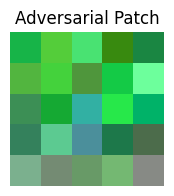

Targeted Attack Success Rate: 0.70%


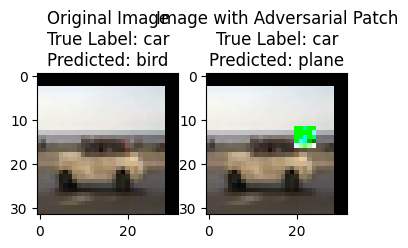

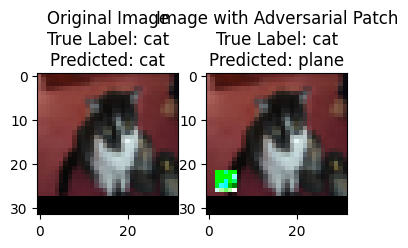

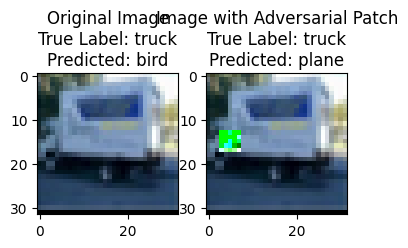

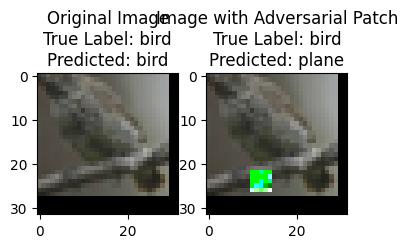

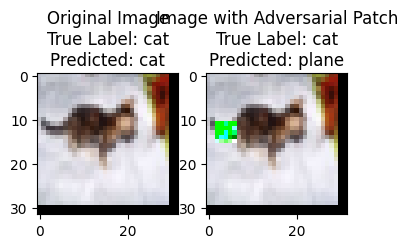


Training for patch size: (7, 7) with target class: plane
Epoch 1/20, Loss: 3.3809
Epoch 2/20, Loss: 3.3783
Epoch 3/20, Loss: 3.3763
Epoch 4/20, Loss: 3.3738
Epoch 5/20, Loss: 3.3759
Epoch 6/20, Loss: 3.3723
Epoch 7/20, Loss: 3.3714
Epoch 8/20, Loss: 3.3735
Epoch 9/20, Loss: 3.3661
Epoch 10/20, Loss: 3.3679
Epoch 11/20, Loss: 3.3666
Epoch 12/20, Loss: 3.3665
Epoch 13/20, Loss: 3.3659
Epoch 14/20, Loss: 3.3663
Epoch 15/20, Loss: 3.3646
Epoch 16/20, Loss: 3.3641
Epoch 17/20, Loss: 3.3656
Epoch 18/20, Loss: 3.3646
Epoch 19/20, Loss: 3.3595
Epoch 20/20, Loss: 3.3644
Visualizing patch of size (7, 7) for target class plane


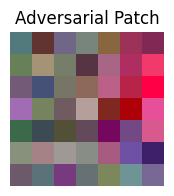

Targeted Attack Success Rate: 0.71%


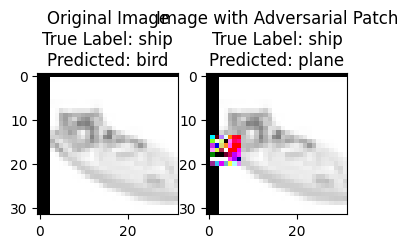

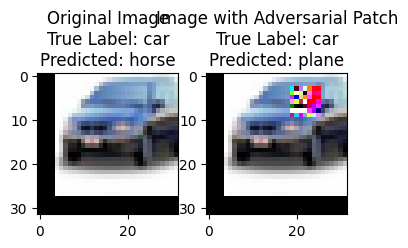

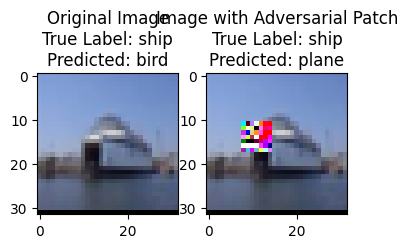

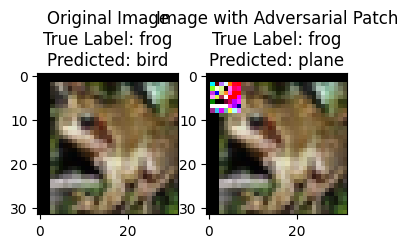

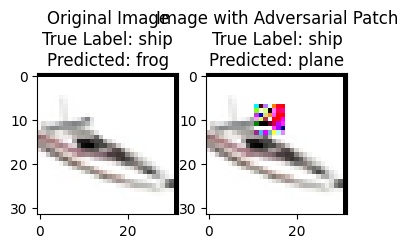


Training for patch size: (16, 16) with target class: plane
Epoch 1/20, Loss: 3.3715
Epoch 2/20, Loss: 3.3643
Epoch 3/20, Loss: 3.3596
Epoch 4/20, Loss: 3.3530
Epoch 5/20, Loss: 3.3475
Epoch 6/20, Loss: 3.3391
Epoch 7/20, Loss: 3.3356
Epoch 8/20, Loss: 3.3314
Epoch 9/20, Loss: 3.3288
Epoch 10/20, Loss: 3.3201
Epoch 11/20, Loss: 3.3146
Epoch 12/20, Loss: 3.3071
Epoch 13/20, Loss: 3.2983
Epoch 14/20, Loss: 3.2891
Epoch 15/20, Loss: 3.2771
Epoch 16/20, Loss: 3.2684
Epoch 17/20, Loss: 3.2607
Epoch 18/20, Loss: 3.2521
Epoch 19/20, Loss: 3.2458
Epoch 20/20, Loss: 3.2401
Visualizing patch of size (16, 16) for target class plane


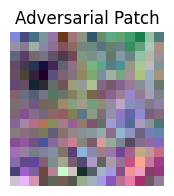

Targeted Attack Success Rate: 0.80%


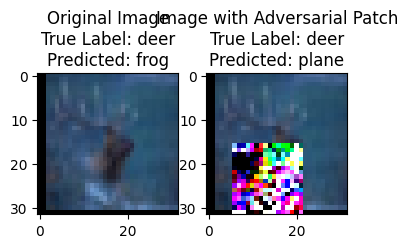

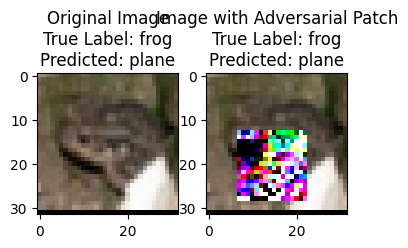

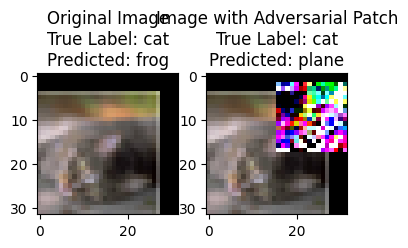

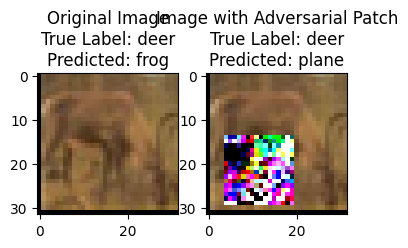

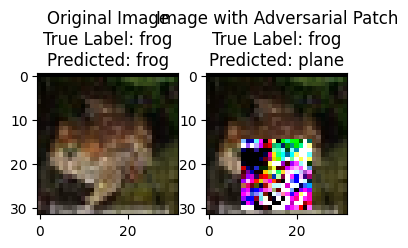


Training for patch size: (3, 3) with target class: car
Epoch 1/20, Loss: 2.2699
Epoch 2/20, Loss: 2.2690
Epoch 3/20, Loss: 2.2702
Epoch 4/20, Loss: 2.2670
Epoch 5/20, Loss: 2.2696
Epoch 6/20, Loss: 2.2695
Epoch 7/20, Loss: 2.2697
Epoch 8/20, Loss: 2.2703
Epoch 9/20, Loss: 2.2692
Epoch 10/20, Loss: 2.2692
Epoch 11/20, Loss: 2.2698
Epoch 12/20, Loss: 2.2659
Epoch 13/20, Loss: 2.2680
Epoch 14/20, Loss: 2.2657
Epoch 15/20, Loss: 2.2679
Epoch 16/20, Loss: 2.2656
Epoch 17/20, Loss: 2.2654
Epoch 18/20, Loss: 2.2637
Epoch 19/20, Loss: 2.2633


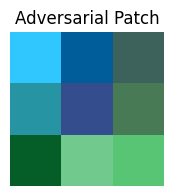

Targeted Attack Success Rate: 15.55%


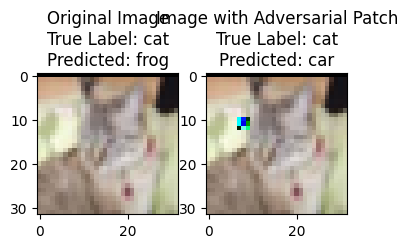

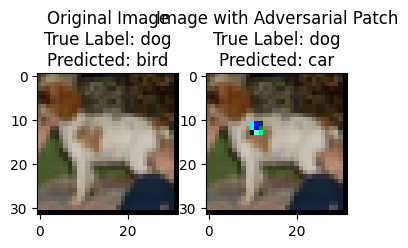

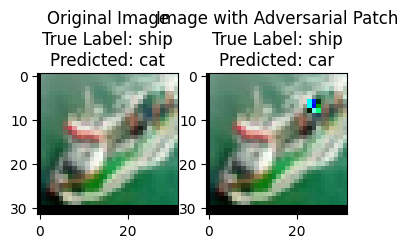

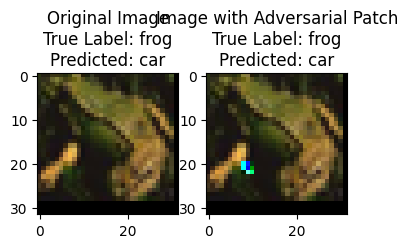

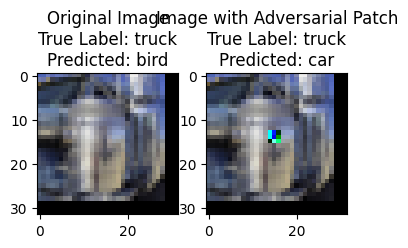


Training for patch size: (5, 5) with target class: car
Epoch 1/20, Loss: 2.2675
Epoch 2/20, Loss: 2.2652
Epoch 3/20, Loss: 2.2612
Epoch 4/20, Loss: 2.2597
Epoch 5/20, Loss: 2.2611
Epoch 6/20, Loss: 2.2607
Epoch 7/20, Loss: 2.2607
Epoch 8/20, Loss: 2.2613
Epoch 9/20, Loss: 2.2580
Epoch 10/20, Loss: 2.2576
Epoch 11/20, Loss: 2.2597
Epoch 12/20, Loss: 2.2577
Epoch 13/20, Loss: 2.2580
Epoch 14/20, Loss: 2.2571
Epoch 15/20, Loss: 2.2556
Epoch 16/20, Loss: 2.2564
Epoch 17/20, Loss: 2.2578
Epoch 18/20, Loss: 2.2559
Epoch 19/20, Loss: 2.2557
Epoch 20/20, Loss: 2.2561
Visualizing patch of size (5, 5) for target class car


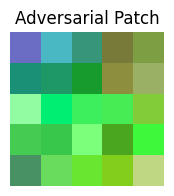

Targeted Attack Success Rate: 15.38%


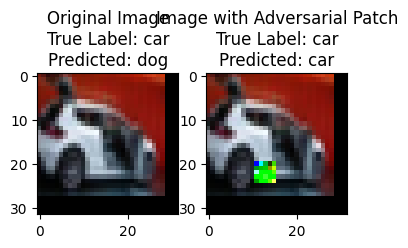

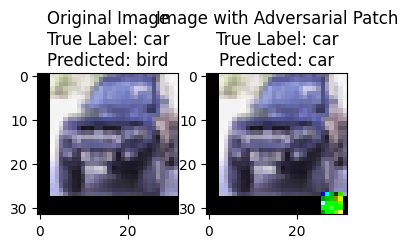

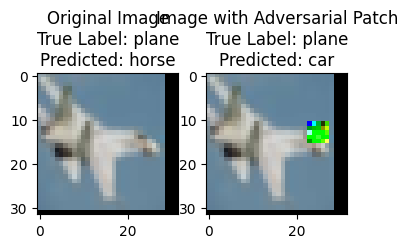

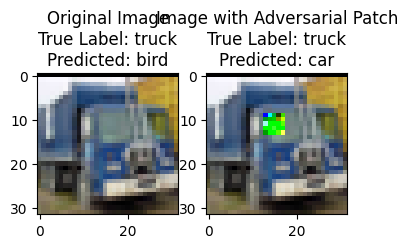

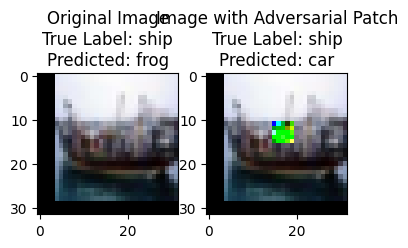


Training for patch size: (7, 7) with target class: car
Epoch 1/20, Loss: 2.2661
Epoch 2/20, Loss: 2.2658
Epoch 3/20, Loss: 2.2648
Epoch 4/20, Loss: 2.2635
Epoch 5/20, Loss: 2.2656
Epoch 6/20, Loss: 2.2635
Epoch 7/20, Loss: 2.2652
Epoch 8/20, Loss: 2.2658
Epoch 9/20, Loss: 2.2638
Epoch 10/20, Loss: 2.2607
Epoch 11/20, Loss: 2.2598
Epoch 12/20, Loss: 2.2603
Epoch 13/20, Loss: 2.2575
Epoch 14/20, Loss: 2.2575
Epoch 15/20, Loss: 2.2575
Epoch 16/20, Loss: 2.2561
Epoch 17/20, Loss: 2.2555
Epoch 18/20, Loss: 2.2542
Epoch 19/20, Loss: 2.2553
Epoch 20/20, Loss: 2.2532
Visualizing patch of size (7, 7) for target class car


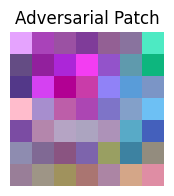

Targeted Attack Success Rate: 15.99%


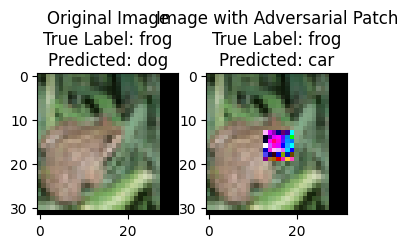

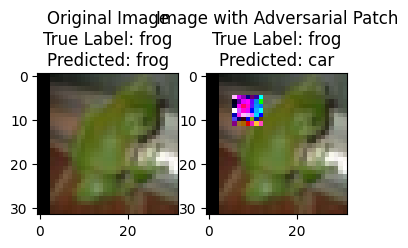

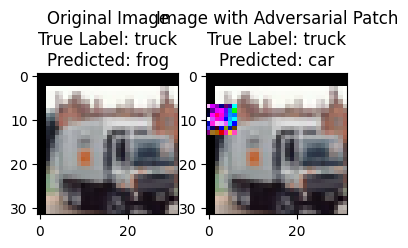

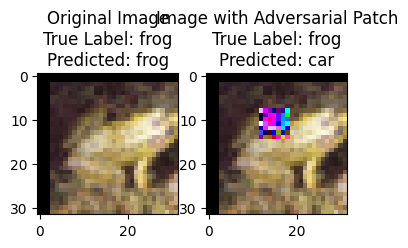

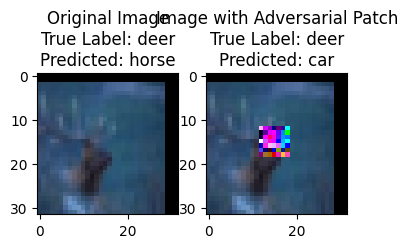


Training for patch size: (16, 16) with target class: car
Epoch 1/20, Loss: 2.2627
Epoch 2/20, Loss: 2.2566
Epoch 3/20, Loss: 2.2529
Epoch 4/20, Loss: 2.2489
Epoch 5/20, Loss: 2.2466
Epoch 6/20, Loss: 2.2480
Epoch 7/20, Loss: 2.2485
Epoch 8/20, Loss: 2.2419
Epoch 9/20, Loss: 2.2408
Epoch 10/20, Loss: 2.2410
Epoch 11/20, Loss: 2.2405
Epoch 12/20, Loss: 2.2401
Epoch 13/20, Loss: 2.2370
Epoch 14/20, Loss: 2.2352
Epoch 15/20, Loss: 2.2348
Epoch 16/20, Loss: 2.2356
Epoch 17/20, Loss: 2.2336
Epoch 18/20, Loss: 2.2323
Epoch 19/20, Loss: 2.2322
Epoch 20/20, Loss: 2.2296
Visualizing patch of size (16, 16) for target class car


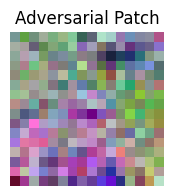

Targeted Attack Success Rate: 16.16%


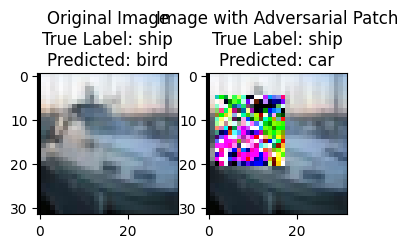

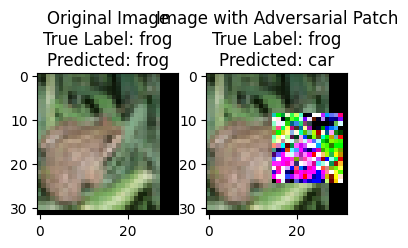

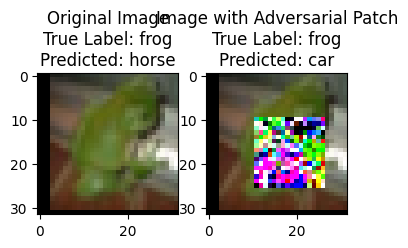

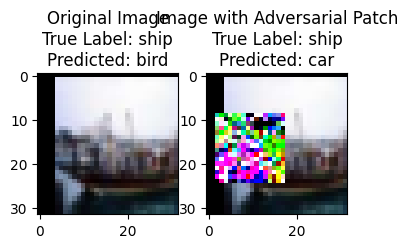

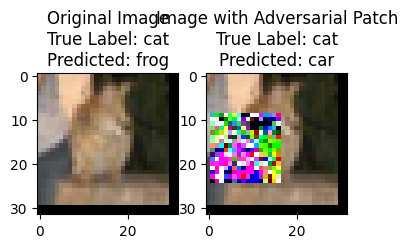


Training for patch size: (3, 3) with target class: bird
Epoch 1/20, Loss: 2.1113
Epoch 2/20, Loss: 2.1080
Epoch 3/20, Loss: 2.1085
Epoch 4/20, Loss: 2.1058
Epoch 5/20, Loss: 2.1061
Epoch 6/20, Loss: 2.1046
Epoch 7/20, Loss: 2.1030
Epoch 8/20, Loss: 2.1021
Epoch 9/20, Loss: 2.1044
Epoch 10/20, Loss: 2.1026
Epoch 11/20, Loss: 2.0999
Epoch 12/20, Loss: 2.0994
Epoch 13/20, Loss: 2.1005
Epoch 14/20, Loss: 2.1002
Epoch 15/20, Loss: 2.1002
Epoch 16/20, Loss: 2.0987
Epoch 17/20, Loss: 2.1000
Epoch 18/20, Loss: 2.0979
Epoch 19/20, Loss: 2.1002
Epoch 20/20, Loss: 2.0991
Visualizing patch of size (3, 3) for target class bird


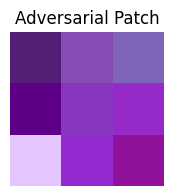

Targeted Attack Success Rate: 17.83%


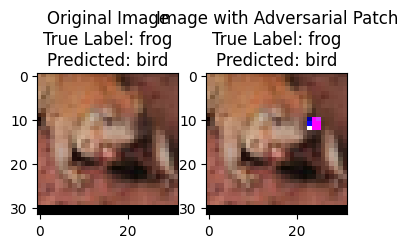

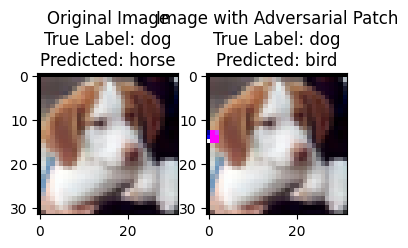

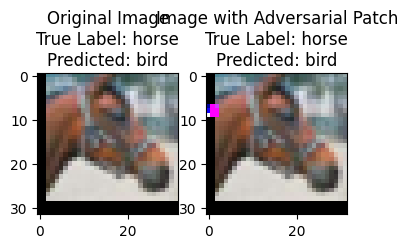

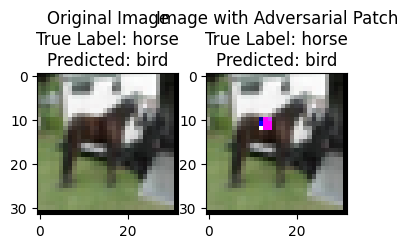

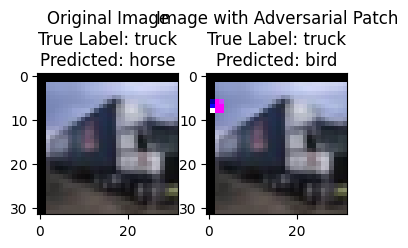


Training for patch size: (5, 5) with target class: bird
Epoch 1/20, Loss: 2.1103
Epoch 2/20, Loss: 2.1089
Epoch 3/20, Loss: 2.1061
Epoch 4/20, Loss: 2.1062
Epoch 5/20, Loss: 2.1026
Epoch 6/20, Loss: 2.1023
Epoch 7/20, Loss: 2.1013
Epoch 8/20, Loss: 2.0998
Epoch 9/20, Loss: 2.0976
Epoch 10/20, Loss: 2.0936
Epoch 11/20, Loss: 2.0963
Epoch 12/20, Loss: 2.0948
Epoch 13/20, Loss: 2.0935
Epoch 14/20, Loss: 2.0946
Epoch 15/20, Loss: 2.0943
Epoch 16/20, Loss: 2.0929
Epoch 17/20, Loss: 2.0931
Epoch 18/20, Loss: 2.0930
Epoch 19/20, Loss: 2.0908
Epoch 20/20, Loss: 2.0901
Visualizing patch of size (5, 5) for target class bird


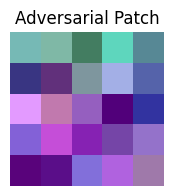

Targeted Attack Success Rate: 17.93%


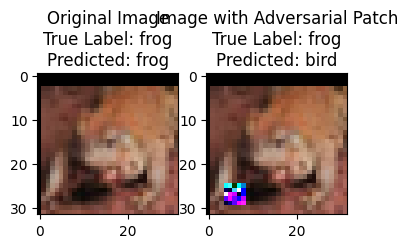

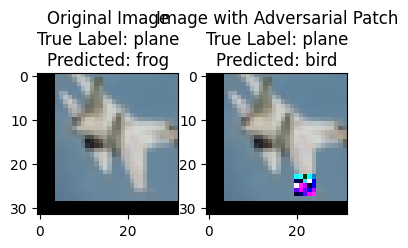

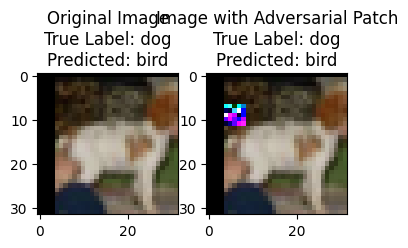

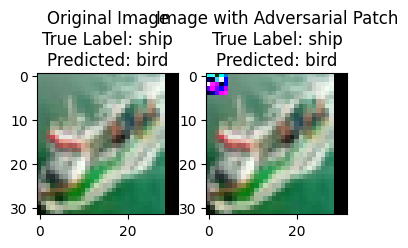

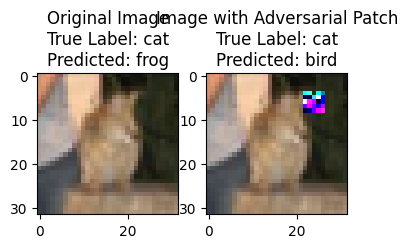


Training for patch size: (7, 7) with target class: bird
Epoch 1/20, Loss: 2.1061
Epoch 2/20, Loss: 2.1011
Epoch 3/20, Loss: 2.1020
Epoch 4/20, Loss: 2.1005
Epoch 5/20, Loss: 2.0954
Epoch 6/20, Loss: 2.0972
Epoch 7/20, Loss: 2.0957
Epoch 8/20, Loss: 2.0955
Epoch 9/20, Loss: 2.0949
Epoch 10/20, Loss: 2.0938
Epoch 11/20, Loss: 2.0941
Epoch 12/20, Loss: 2.0926
Epoch 13/20, Loss: 2.0917
Epoch 14/20, Loss: 2.0913
Epoch 15/20, Loss: 2.0916
Epoch 16/20, Loss: 2.0904
Epoch 17/20, Loss: 2.0904
Epoch 18/20, Loss: 2.0903
Epoch 19/20, Loss: 2.0893
Epoch 20/20, Loss: 2.0896
Visualizing patch of size (7, 7) for target class bird


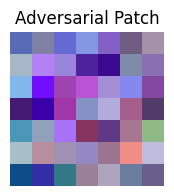

Targeted Attack Success Rate: 19.40%


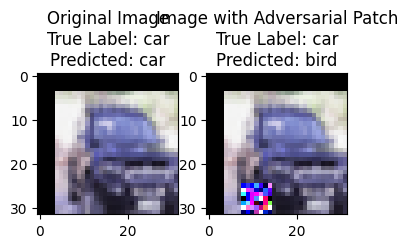

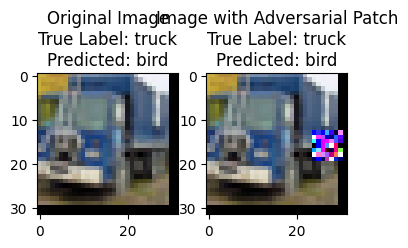

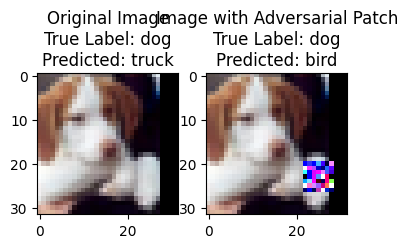

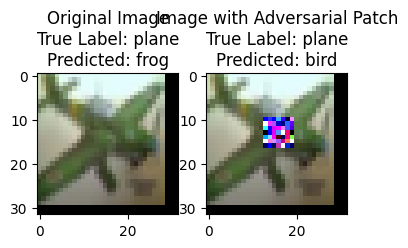

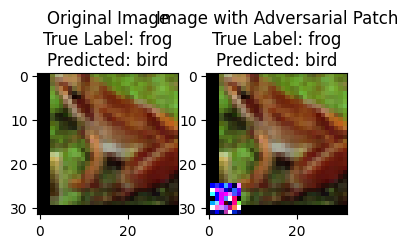


Training for patch size: (16, 16) with target class: bird
Epoch 1/20, Loss: 2.0942
Epoch 2/20, Loss: 2.0859
Epoch 3/20, Loss: 2.0822
Epoch 4/20, Loss: 2.0820
Epoch 5/20, Loss: 2.0791
Epoch 6/20, Loss: 2.0781
Epoch 7/20, Loss: 2.0756
Epoch 8/20, Loss: 2.0733
Epoch 9/20, Loss: 2.0709
Epoch 10/20, Loss: 2.0702
Epoch 11/20, Loss: 2.0682
Epoch 12/20, Loss: 2.0648
Epoch 13/20, Loss: 2.0643
Epoch 14/20, Loss: 2.0621
Epoch 15/20, Loss: 2.0605
Epoch 16/20, Loss: 2.0584
Epoch 17/20, Loss: 2.0540
Epoch 18/20, Loss: 2.0543
Epoch 19/20, Loss: 2.0501
Epoch 20/20, Loss: 2.0461
Visualizing patch of size (16, 16) for target class bird


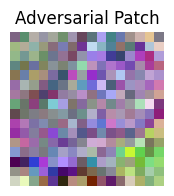

Targeted Attack Success Rate: 20.23%


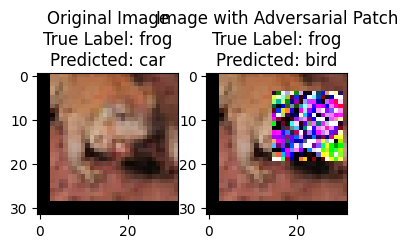

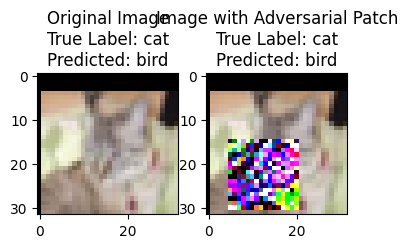

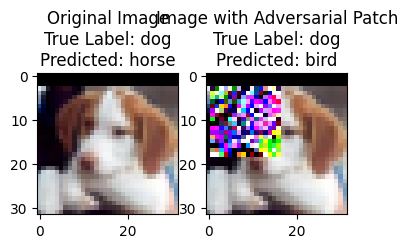

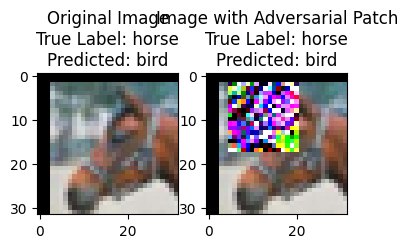

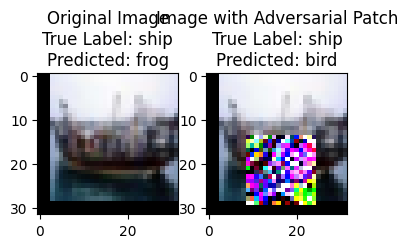

In [ ]:
# CIFAR-10 class names
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Targeted classes (plane, car, bird)
target_classes = [0, 1, 2]  # Corresponding to 'plane', 'car', and 'bird'

# Different patch sizes
patch_sizes = [(3, 3), (5, 5), (7, 7), (16, 16)]

# Train and evaluate patches for each target class
for target_class in target_classes:
    for patch_size in patch_sizes:
        print(f"\nTraining for patch size: {patch_size} with target class: {classes[target_class]}")
        patch = create_patch(patch_size)
        train_adversarial_patch(model, patch, target_class=target_class, num_epochs=20)

        # Save the patch
        torch.save(patch, f'adversarial_patch_{patch_size[0]}x{patch_size[1]}_target_{target_class}.pth')

        # Visualize the patch
        print(f"Visualizing patch of size {patch_size} for target class {classes[target_class]}")
        visualize_patch(patch)

        # Evaluate attack success rate
        evaluate_patch_success_rate(model, patch, testloader, target_class=target_class)

        # Visualize misclassified examples with the adversarial patch
        visualize_misclassified_patched_images(model, patch, testloader, classes, target_class, num_examples=5)
